###### <span style="color: gray ">ライブラリをまとめてインポート</span>

In [1]:
# 数値計算およびデータ分析用ライブラリ
import numpy as np  # 数値計算を効率的に行うためのライブラリ
import pandas as pd  # データ分析を容易にするためのライブラリ

# グラフ描画用ライブラリ
import matplotlib.pyplot as plt  # グラフ描画のためのライブラリ
from matplotlib.colors import ListedColormap  # カラーマップを作成するためのモジュール
import seaborn as sns  # グラフ描画用ライブラリ（Matplotlibをベースにした高水準インターフェース）

# 統計および信号処理関数用ライブラリ
from scipy import stats  # 統計関数を扱うモジュール
from scipy import signal  # 信号処理関数を扱うモジュール
from scipy.signal import savgol_filter  # Savitzky-Golayフィルターを適用するためのモジュール
from scipy.optimize import curve_fit  # カーブフィッティングを行うための関数
from scipy.special import wofz  # Faddeeva関数を計算するための関数

# 機械学習モデルおよび評価関数
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # データ分割、グリッドサーチ、クロスバリデーション
from sklearn.cross_decomposition import PLSRegression  # 部分最小二乗回帰モデル
from sklearn.svm import SVR, SVC  # サポートベクターマシン（回帰、分類）
from sklearn.pipeline import Pipeline  # パイプラインの作成
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report  # 評価指標
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier  # アンサンブル学習（外れ値検出、回帰、分類）
from sklearn.preprocessing import FunctionTransformer  # 関数変換器
from sklearn.decomposition import PCA  # 主成分分析
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # 線形判別分析
from sklearn.linear_model import LinearRegression  # 線形回帰

# その他のライブラリ
from tqdm import tqdm  # プログレスバー表示
import pickle  # オブジェクトの直列化・非直列化
from xgboost import XGBRegressor  # XGBoost回帰モデル


# <span style="color:RoyalBlue; ">10.1 スペクトルデータの読み込み</span>

###### <span style="color: gray ">コード10.1　CSVファイルの読み込み</span>

In [4]:
file_spe = 'dataChapter10-11/spectra.csv'
file_prop = 'dataChapter10-11/prop.csv'
# CSVファイルを読み込む。A列をカラム名、1行目をインデックス名とする
spectra = pd.read_csv(file_spe, index_col=0, header=0)
spectra=spectra.T
prop = pd.read_csv(file_prop, index_col=0, header=0)

###### <span style="color: gray ">コード10.2　データフレームへのラベルの追加とデータの概要の確認</span>

In [5]:
# propというデータフレームの新しい列'label'を作成し、初期値としてNoneを設定
prop['label'] = None
# propデータフレームのインデックスが'Aga'で始まる行の'label'列に0を設定
prop.loc[prop.index.str.startswith('Aga'), 'label'] = 0
# propデータフレームのインデックスが'Kiri'で始まる行の'label'列に1を設定
prop.loc[prop.index.str.startswith('Kiri'), 'label'] = 1
# propデータフレームの'label'列のデータ型を整数型(int)に変換
prop['label'] = prop['label'].astype(int)
# propデータフレームの要約統計量を表示
prop.describe()

,mc,label
count,106.000000,106.000000
mean,50.780579,0.500000
std,19.649163,0.502375
min,0.000000,0.000000
25%,37.557799,0.000000
50%,54.073725,0.500000
75%,67.231813,1.000000
max,81.967213,1.000000


# <span style="color:RoyalBlue; ">10.2 箱ひげ図による目的変数の分布の把握</span>

箱ひげ図（Boxplot）は、データの分布を視覚的に表現するためのグラフで、以下のようなデータの特徴を可視化します：
- <span style="color: blue; ">中央値（Median)</span> <BR>
箱の中央にある線（または点）で、データの中央値を示します。データを半分に分ける値で、下半分と上半分の中央に位置します。
<BR><BR>
- <span style="color: blue; ">四分位範囲（Interquartile Range, IQR）</span><BR>
箱の上下の端は、第一四分位数（Q1、下側四分位数）と第三四分位数（Q3、上側四分位数）を示しており、これらの間の範囲（Q3 - Q1）を四分位範囲と呼びます。この範囲は、データの中央50%を含んでいます。
<BR><BR>
- <span style="color: blue; ">外れ値（Outliers）</span><BR>箱から離れた点としてプロットされ、通常、Q1またはQ3から1.5倍IQR以上離れた値として定義されます。外れ値は、データの分布における異常値や特異な値を示します。
<BR><BR>
- <span style="color: blue; ">最大値と最小値（Whiskers）</span><BR>箱の外側に伸びる線（ヒゲ）は、外れ値を除いたデータの最大値と最小値を示しています。ヒゲの長さは、データの散らばり具合を表しますが、外れ値の影響を受けにくい方法で計算されます。

###### <span style="color: gray ">データ10.3　箱ひげ図とヒストグラムを表示する関数</span>

In [7]:
def plot_boxplot_and_histogram(prop_data, bins=10):
    """
    データのボックスプロットとヒストグラムを表示する関数。

    Parameters:
    prop_data (array-like): プロットするデータ
    bins (int): ヒストグラムのビン数（デフォルトは10）

    Returns:
    None
    """
    plt.figure(figsize=(8, 5))

    # ボックスプロット
    plt.subplot(1, 2, 1)
    boxplot_dict = plt.boxplot(prop_data, whis=1.5, patch_artist=True)
    plt.title('Boxplot')

    # ヒストグラム
    plt.subplot(1, 2, 2)
    plt.hist(prop_data, bins=bins, color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.tight_layout()
    plt.show()
    
    # 四分位数（Q1, Q3）とIQRの計算
    Q1 = np.percentile(prop_data, 25)
    Q3 = np.percentile(prop_data, 75)
    IQR = Q3 - Q1

    # 最大、最小の範囲
    whiskers = [item.get_ydata() for item in boxplot_dict['whiskers']]
    lower_whisker = whiskers[0][1]
    upper_whisker = whiskers[1][1]

    # 外れ値
    fliers = [item.get_ydata() for item in boxplot_dict['fliers']]
    outliers = fliers[0] if fliers else []  # 外れ値がない場合は空のリスト

    # 結果の出力
    print(f"Q1 (第一四分位数): {Q1}")
    print(f"Q3 (第三四分位数): {Q3}")
    print(f"IQR (四分位範囲): {IQR}")
    print(f"最小: {lower_whisker}")
    print(f"最大: {upper_whisker}")
    print(f"外れ値: {outliers}")

###### <span style="color: gray ">コード10.4　関数plot_boxplot_and_histogramの実行</span>

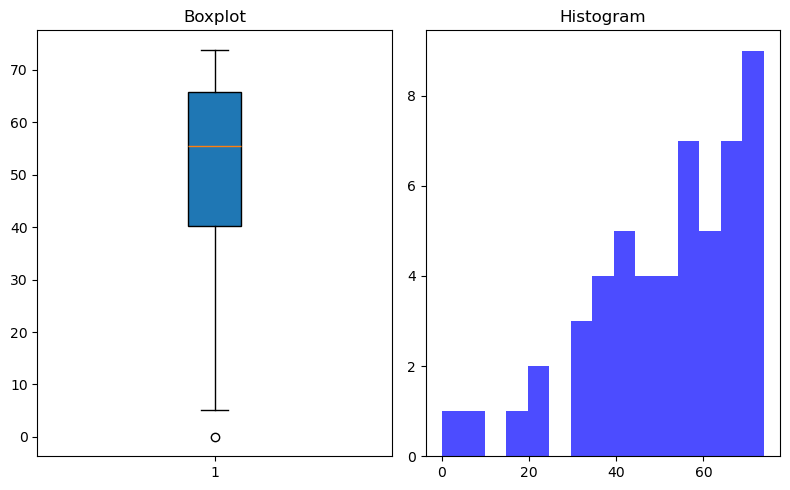

Q1 (第一四分位数): 40.32059186
Q3 (第三四分位数): 65.72133169
IQR (四分位範囲): 25.40073983
最小: 5.055487053
最大: 73.8594328
外れ値: [0.]


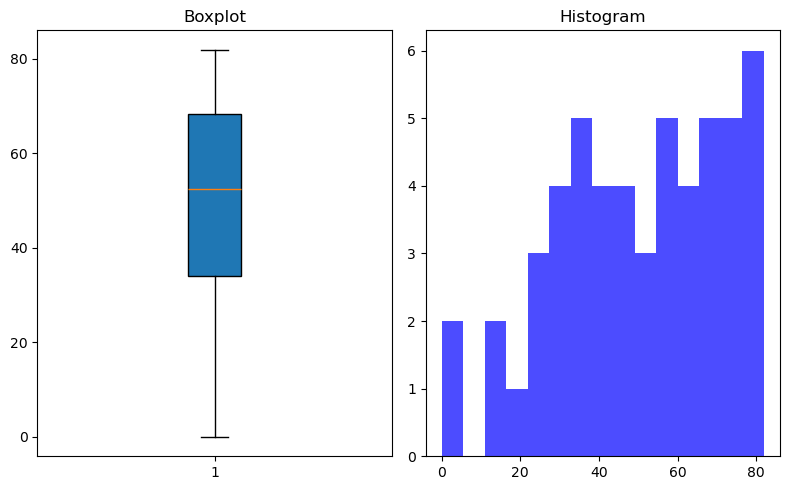

Q1 (第一四分位数): 34.01639344
Q3 (第三四分位数): 68.44262295
IQR (四分位範囲): 34.42622951
最小: 0.0
最大: 81.96721311
外れ値: []


In [8]:
mc_0 = prop[prop['label'] == 0]['mc']
mc_1 = prop[prop['label'] == 1]['mc']
plot_boxplot_and_histogram(mc_0, bins=15)
plot_boxplot_and_histogram(mc_1, bins=15)

# <span style="color:RoyalBlue; ">10.3 スペクトル表示</span>

###### <span style="color: gray ">コード10.5　スペクトルをプロットする関数</span>

In [9]:
def plot_spectra(wave, spec):
    """
    スペクトルをプロットする関数。

    Parameters:
    wave (numpy.ndarray): 波長の配列
    spec (numpy.ndarray): 吸収スペクトルの配列（行がサンプル、列が波長）

    Returns:
    None
    """   
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(wave, spec.T)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Absorbance')
    ax.set_title('Spectra')

    plt.show()

###### <span style="color: gray ">コード10.6　関数plot_spectraの実行</span>

<IPython.core.display.Javascript object>


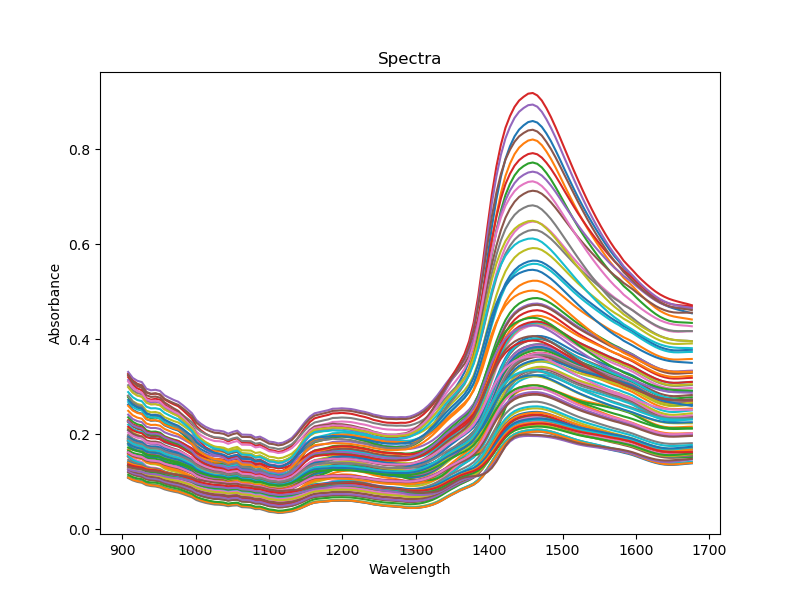

In [10]:
plot_spectra(spectra.columns, spectra)

# <span style="color:RoyalBlue; ">10.4 ピーク検出</span>

###### <span style="color: gray ">コード10.7　スペクトルデータからピークを検出する関数</span>

In [11]:
# スペクトルデータからピークを検出する関数
def detect_peaks(wave, spec, num_smooth):
    """
    Parameters:
    wave (numpy.ndarray): 波長データ
    spec (numpy.ndarray or pandas.DataFrame): スペクトルデータ
    num_smooth (int): スペクトルデータを平滑化するための窓幅

    Returns:
    None
    """
    # スペクトルデータを配列に変換
    spec_array = spec.values if not isinstance(spec, np.ndarray) else spec

    # ①スペクトルデータの2次微分を取得
    derispec_array = signal.savgol_filter(spec_array, num_smooth, 2, 2)

     #②元の吸光度スペクトルデータからピークを検出
    spec_peaks_posi, _ = signal.find_peaks(spec_array)

    # ③2次微分スペクトルデータから負のピークを検出
    derispec_peaks_posi, _ = signal.find_peaks(-derispec_array)

    # 元の吸光度スペクトルデータとそのピークをプロット
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(wave, spec_array, color='cyan', label='Spectra')
    plt.plot(wave[spec_peaks_posi], spec_array[spec_peaks_posi], "o", label='Positive Peaks')
    for i, txt in enumerate(spec_peaks_posi):
        plt.text(wave[txt], spec_array[txt], f"{wave[txt]:.2f}", fontsize=8, verticalalignment='bottom')
    plt.title('Spectra and Positive Peaks')
    plt.xlabel('Wavelength')
    plt.legend()

    # 二次微分スペクトルとその負のピークをプロット
    plt.subplot(2, 1, 2)
    plt.plot(wave, derispec_array, color='cyan', label='Derispec')
    plt.plot(wave[derispec_peaks_posi], derispec_array[derispec_peaks_posi], "o", label='Negative Peaks')
    for i, txt in enumerate(derispec_peaks_posi):
        plt.text(wave[txt], derispec_array[txt], f"{wave[txt]:.2f}", fontsize=8, verticalalignment='bottom')
    plt.title('Derispec and Negative Peaks')
    plt.xlabel('Wavelength')
    plt.legend()
    plt.show()


###### <span style="color: gray ">コード10.8　関数detect_peaksの実行</span>

<IPython.core.display.Javascript object>


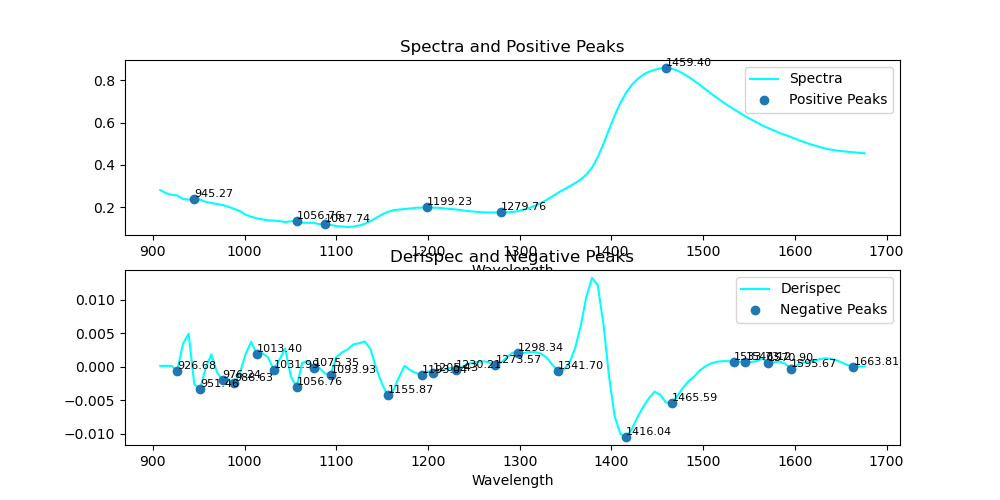

In [12]:
detect_peaks(spectra.columns,spectra.iloc[0,:],5)

# <span style="color:RoyalBlue; ">10.5 相関スペクトル</span>

###### <span style="color: gray ">コード10.9　スペクトルデータと目的関数の相関スペクトルをプロットする関数</span>

In [13]:
def plot_correlation_spectrum(wave, spec, num_smooth, propdata):
    """
    Parameters:
    wave (numpy.ndarray): 波長データ
    spec(pandas.DataFrame): スペクトルデータ
    num_smooth (int): 平滑化のための窓幅
    propdata (numpy.ndarray): 目的変数（プロパティ）データ

    Returns:
    numpy.ndarray: 二次微分スペクトルと目的変数の相関係数
    """
    # スペクトルデータの二次微分を計算
    derispec = signal.savgol_filter(spec, num_smooth, 2, 2)
    
    #①各波長における吸光度スペクトルと目的変数の相関係数を計算
    spec_corr = np.array([np.corrcoef(spec.iloc[:, i], propdata)[0, 1] for i in range(spec.shape[1])])
    
    #②各波長における二次微分スペクトルと目的変数の相関係数を計算
    derispec_corr = np.array([np.corrcoef(derispec[:, i], propdata)[0, 1] for i in range(derispec.shape[1])])
    
    # 相関スペクトルをプロット
    plt.figure(figsize=(10, 8))
    
    # 吸光度スペクトルと目的変数との相関スペクトルをプロット
    plt.subplot(4, 1, 1)
    plt.plot(wave, spec.T, label='Spectra')
    
    plt.subplot(4, 1, 2)
    plt.plot(wave, spec_corr)
    plt.title('Correlation Spectrum for Spectra')
    plt.xlabel('Wavelength')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)
    plt.legend()
    
    # 二次微分スペクトルと目的変数との相関スペクトルをプロット
    plt.subplot(4, 1, 3)
    plt.plot(wave, derispec.T, label='Derispectra')
    
    plt.subplot(4, 1, 4)
    plt.plot(wave, derispec_corr)  # 二次微分スペクトルの波長調整
    plt.title('Correlation Spectrum for Derispectra')
    plt.xlabel('Wavelength')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return derispec_corr


###### <span style="color: gray ">コード10.10　関数plot_correlation_spectrumの実行</span>

<IPython.core.display.Javascript object>


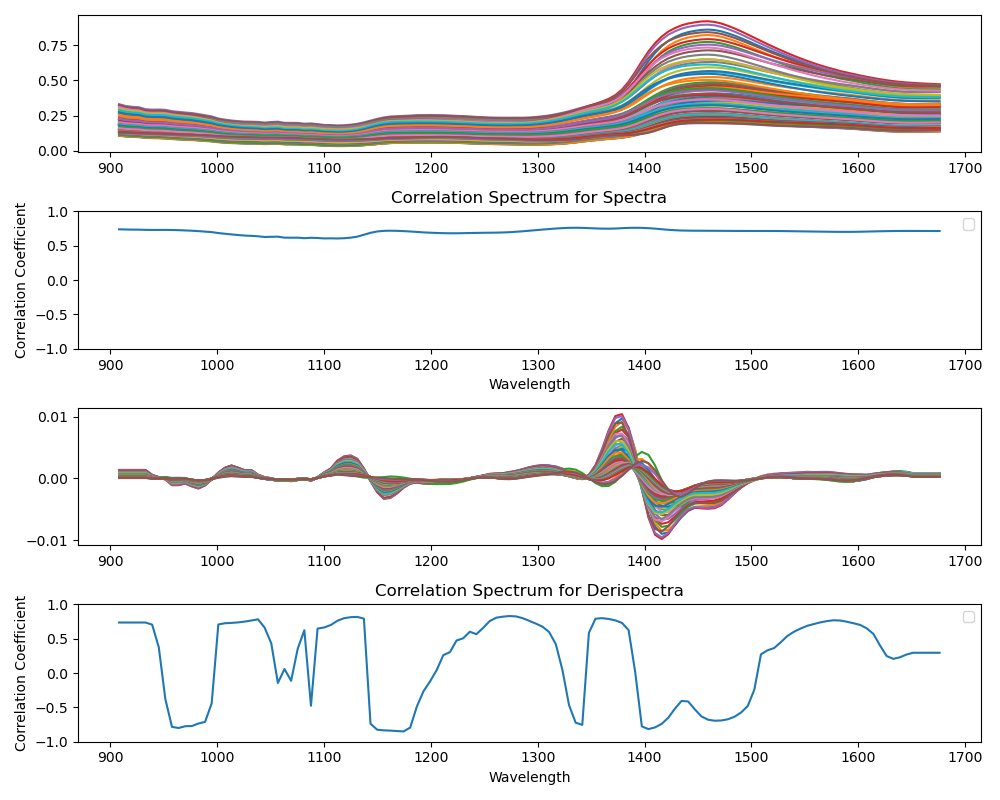

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [14]:
derispec_corr=plot_correlation_spectrum(spectra.columns,spectra,9,prop["mc"])

# <span style="color:RoyalBlue; ">10.6 ベースライン補正</span>

###### <span style="color: gray ">コード10.11　ベースライン補正とスペクトルの面積を計算する関数</span>

In [15]:
def baseline_shift(wave, spec, wave1, wave2):
    """
    スペクトルデータのベースライン補正を行い、補正後のスペクトルデータの面積を計算する関数。

    Parameters:
    wave (numpy.ndarray): 波長データ
    spec (pandas.DataFrame): スペクトルデータ
    wave1 (float): ベースライン補正の開始波長
    wave2 (float): ベースライン補正の終了波長

    Returns:
    numpy.ndarray: ベースライン補正後の波長データ
    pandas.DataFrame: ベースライン補正後のスペクトルデータ
    pandas.Series: ベースライン補正後のスペクトルデータの面積
    """
    # 指定された2つの波長に最も近い波長のインデックスを見つける
    wave1_col = np.abs(wave - wave1).argmin()
    wave2_col = np.abs(wave - wave2).argmin()

    # 1次関数の傾きと切片を計算
    slope = (spec.iloc[:, wave2_col] - spec.iloc[:, wave1_col]) / (wave[wave2_col] - wave[wave1_col])
    intercept = spec.iloc[:, wave1_col] - slope * wave[wave1_col]

    # スペクトルデータのコピーを作成し、ベースライン補正を実行
    shifted_spec = spec.copy()
    for ind in range(len(spec)):
        shifted_spec.iloc[ind, wave1_col:wave2_col + 1] = spec.iloc[ind, wave1_col:wave2_col + 1] - \
                                                          (slope.iloc[ind] * wave[wave1_col:wave2_col + 1] + intercept.iloc[ind])

    # ベースライン補正後のスペクトルデータの抽出
    shifted_spec = shifted_spec.iloc[:, wave1_col:wave2_col + 1]
    shifted_wave = wave[wave1_col:wave2_col + 1]

    # ベースライン補正後のスペクトルデータの面積を計算
    integ_spec = shifted_spec.sum(axis=1)
    
    # 元のスペクトル、ベースライン補正後のスペクトル、スペクトルの面積をプロット
    plt.figure(figsize=(10, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(wave, spec.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    plt.title('Spectra')

    plt.subplot(3, 1, 2)
    plt.plot(shifted_wave, shifted_spec.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    plt.title('Shifted Spectra')

    plt.subplot(3, 1, 3)
    plt.scatter(range(1, len(integ_spec) + 1), integ_spec)
    plt.xlabel('Sample Number')
    plt.ylabel('Integrated Absorbance')
    plt.title('Integrated Spectra')

    plt.tight_layout()
    plt.show()
    
    return shifted_wave, shifted_spec, integ_spec


###### <span style="color: gray ">コード10.12　関数baseline_shiftの実行</span>

<IPython.core.display.Javascript object>


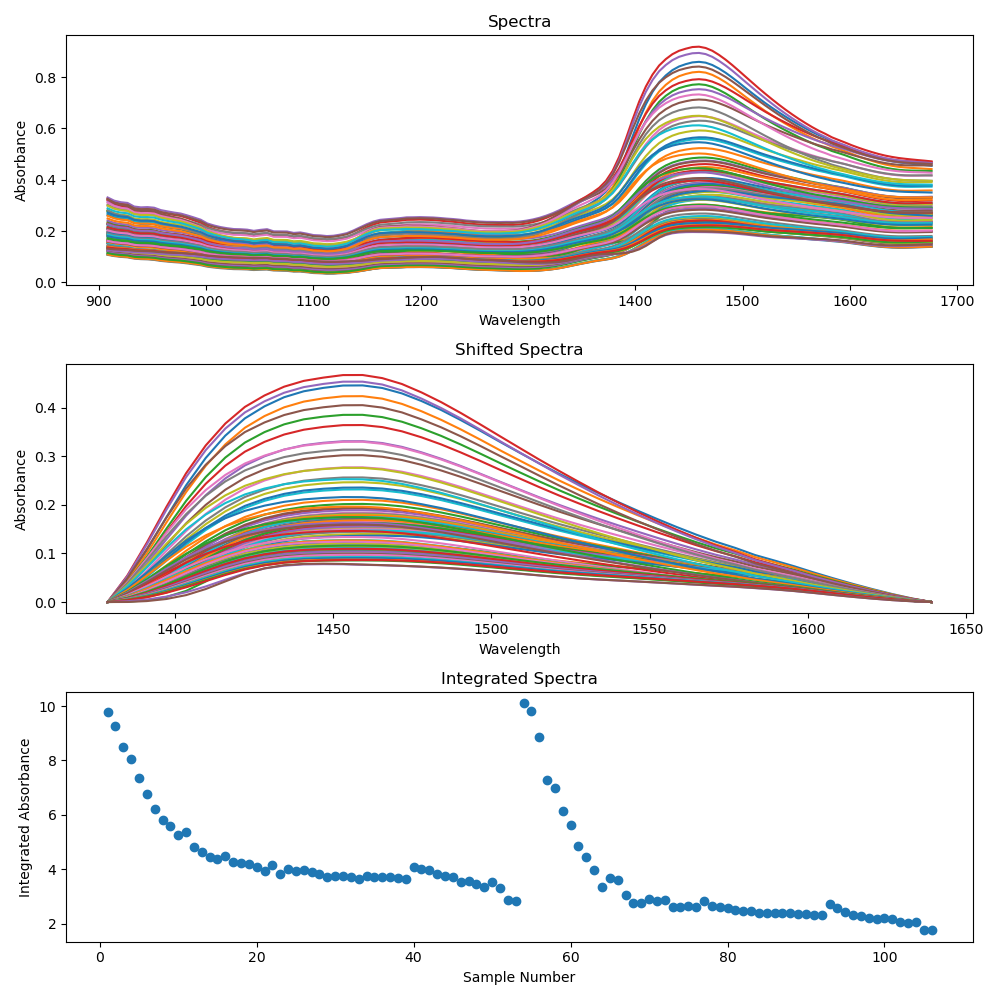

In [16]:
shifted_wave,shifted_spec,integ_spec=baseline_shift(spectra.columns,spectra,1381,1641)

# <span style="color:RoyalBlue; ">10.7 カーブフィッティング</span>

###### <span style="color: gray ">コード10.13　補正後のスペクトルのピーク位置</span>

<IPython.core.display.Javascript object>


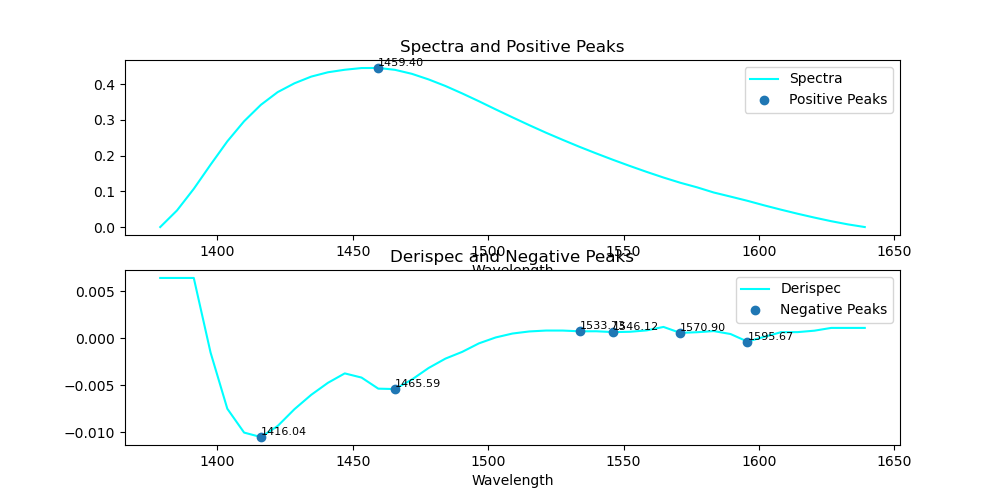

In [17]:
detect_peaks(shifted_wave,shifted_spec.iloc[0,:],5)

###### <span style="color: gray ">コード10.14　フォークト関数によるカーブフィッティング</span>

In [18]:
# ①Voigt関数の定義
def voigt(x, amplitude, mean, sigma, gamma):
    z = ((x - mean) + 1j * gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# ②2つのVoigt関数の合成
def voigt_double(x, amp1, mean1, sigma1, gamma1, amp2, mean2, sigma2, gamma2):
    return voigt(x, amp1, mean1, sigma1, gamma1) + voigt(x, amp2, mean2, sigma2, gamma2)

# 2つのVoigt関数でフィッティングする関数
def fit_voigt_double(wavelength, spec, initial_peak_positions):
    """
    スペクトルデータにVoigt関数を2つフィッティングし、ピーク位置、面積、半値全幅を計算する関数。
    Parameters:
    wavelength (numpy.ndarray): 波長データ
    spec (numpy.ndarray): スペクトルデータ（各行が1つのスペクトル）
    initial_peak_positions (list): ピーク位置の初期値のリスト

    Returns:
    list: フィッティング結果のリスト（各要素はピーク位置、面積、半値全幅のタプル）
    """
    results = []
    plt.figure(figsize=(12, 8))
    
    # ③各スペクトルに対してフィッティングを行う
    for i, specs in enumerate(tqdm(spec, desc="Fitting progress")):
        max_index1 = np.argmin(np.abs(wavelength - initial_peak_positions[0]))
        max_index2 = np.argmin(np.abs(wavelength - initial_peak_positions[1]))
        initial_guess = [specs[max_index1], initial_peak_positions[0], 100, 1, specs[max_index2], initial_peak_positions[1], 100, 1]

        #④パラメータの下限と上限を設定
        lower_bounds = [0, wavelength[0], 0, 0, 0, wavelength[0], 0, 0]
        upper_bounds = [np.inf, wavelength[-1], np.inf, np.inf, np.inf, wavelength[-1], np.inf, np.inf]

        #⑤curve_fitでフィッティングを実行
        popt, pcov = curve_fit(voigt_double, wavelength, specs, p0=initial_guess, bounds=(lower_bounds, upper_bounds))

        perr = np.sqrt(np.diag(pcov))

        # フィッティング結果からピーク位置、面積、半値全幅を計算
        peak_position1 = popt[1]
        peak_position2 = popt[5]
        area1 = popt[0] * (np.sqrt(2 * np.pi) * np.abs(popt[2]) + 2 * np.abs(popt[3]))
        area2 = popt[4] * (np.sqrt(2 * np.pi) * np.abs(popt[6]) + 2 * np.abs(popt[7]))
        fwhm1 = 2 * np.sqrt(2 * np.log(2)) * (np.abs(popt[2]) + np.abs(popt[3]))
        fwhm2 = 2 * np.sqrt(2 * np.log(2)) * (np.abs(popt[6]) + np.abs(popt[7]))

        results.append((peak_position1, area1, fwhm1, peak_position2, area2, fwhm2, perr))
        
        # 最初のスペクトルとフィッティング結果をプロット
        if i == 0:
            plt.subplot(4, 2, 1)
            plt.plot(wavelength, specs, 'k-', label='Original Spectrum')
            plt.plot(wavelength, voigt(wavelength, popt[0], popt[1], popt[2], popt[3]), 'm--', label='Voigt Fit 1')
            plt.plot(wavelength, voigt(wavelength, popt[4], popt[5], popt[6], popt[7]), 'c--', label='Voigt Fit 2')
            plt.plot(wavelength, voigt_double(wavelength, *popt), 'r--', label='Double Voigt Fit')
            plt.xlabel('Wavelength')
            plt.ylabel('Absorbance')
            plt.legend()
    
    # フィッティング結果のプロット
    sample_numbers = range(1, len(results) + 1)
    peak_positions1 = [result[0] for result in results]
    peak_positions2 = [result[3] for result in results]
    areas1 = [result[1] for result in results]
    areas2 = [result[4] for result in results]
    fwhms1 = [result[2] for result in results]
    fwhms2 = [result[5] for result in results]
    errors = [np.mean(result[6]) for result in results]

    plt.subplot(4, 2, 3)
    plt.scatter(sample_numbers, peak_positions1, c='m')
    plt.xlabel('Sample Number')
    plt.ylabel('Peak Position 1')

    plt.subplot(4, 2, 4)
    plt.scatter(sample_numbers, peak_positions2, c='c')
    plt.xlabel('Sample Number')
    plt.ylabel('Peak Position 2')

    plt.subplot(4, 2, 5)
    plt.scatter(sample_numbers, areas1, c='m')
    plt.xlabel('Sample Number')
    plt.ylabel('Area 1')

    plt.subplot(4, 2, 6)
    plt.scatter(sample_numbers, areas2, c='c')
    plt.xlabel('Sample Number')
    plt.ylabel('Area 2')

    plt.subplot(4, 2, 7)
    plt.scatter(sample_numbers, fwhms1, c='m')
    plt.xlabel('Sample Number')
    plt.ylabel('FWHM 1')

    plt.subplot(4, 2, 8)
    plt.scatter(sample_numbers, fwhms2, c='c')
    plt.xlabel('Sample Number')
    plt.ylabel('FWHM 2')

    plt.subplot(4, 2, 2)
    plt.scatter(sample_numbers, errors, c='k')
    plt.xlabel('Sample Number')
    plt.ylabel('Average Fitting Error')

    plt.tight_layout()
    plt.show()   
    return results


###### <span style="color: gray ">コード10.15　関数fit_resultsの実行</span>

<IPython.core.display.Javascript object>


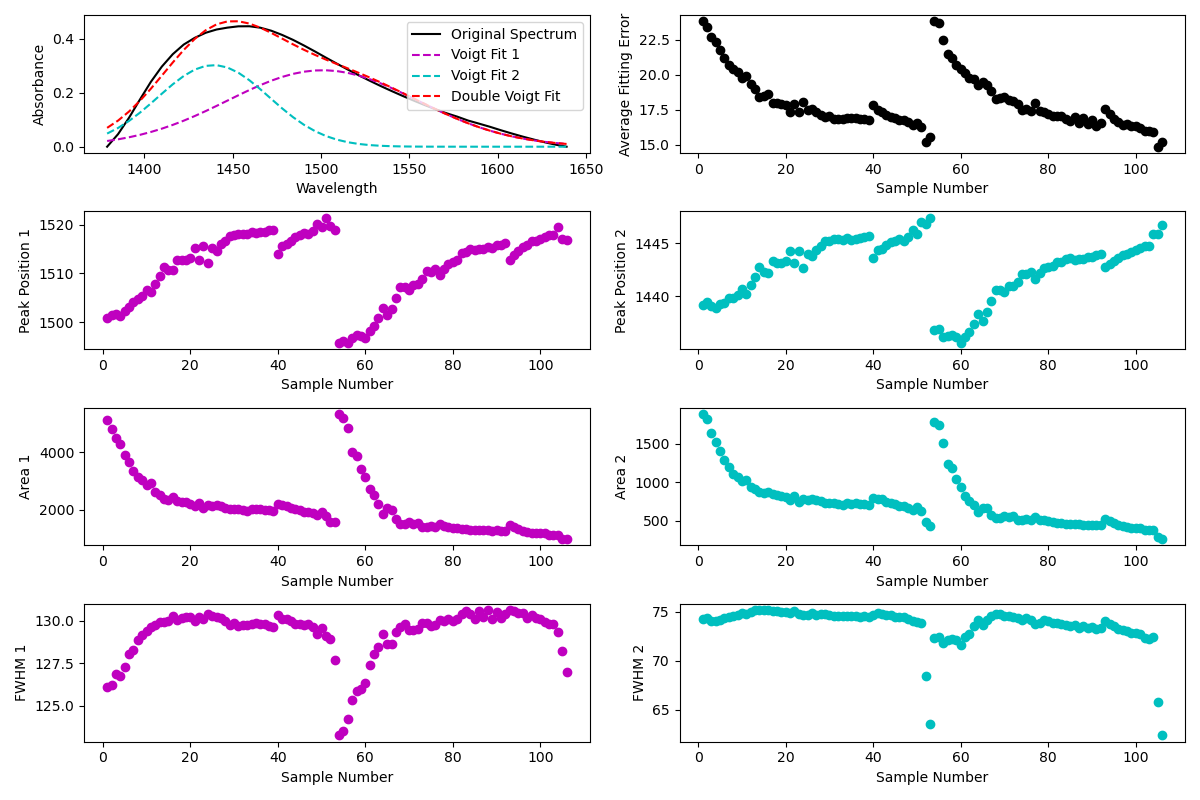

Fitting progress: 100%|██████████████████████████████████████████████████████████████| 106/106 [00:04<00:00, 24.29it/s]


In [19]:
fit_results =  fit_voigt_double(shifted_wave, shifted_spec.values,[1410,1450])

# <span style="color:RoyalBlue; ">10.8 ヒートマップによるスペクトル表示</span>

###### <span style="color: gray ">コード10.16　スペクトルデータをヒートマップで表示する関数</span>

In [22]:
def plot_spectra_heatmap(wave,spec,vmin=None, vmax=None):
    """
    スペクトルデータをプロットとヒートマップで表示する関数。

    Parameters:
    wave (pandas.Index or list): 波長データ
    spec (pandas.DataFrame): スペクトルデータ（行が試料、列が波長）
    vmin (float, optional): ヒートマップの最小値
    vmax (float, optional): ヒートマップの最大値

    Returns:
    None
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(wave,spec.T)
    plt.xlabel('Wavelength')
    plt.ylabel('spectra')
    plt.title('Spectra')

    # ヒートマップの作成
    plt.subplot(2, 1, 2)
    sns.heatmap(spec, cmap='RdBu_r', vmin=vmin, vmax=vmax, yticklabels=False, 
                cbar_kws={'label': 'Absorbance'}, xticklabels=[])
    #二次微分ようにcmap='RdBu_r'を用いているがIR等ではcmap='Reds'がおすすめです
    plt.xlabel('Wavelength')
    plt.ylabel('Sample')


    plt.show()

###### <span style="color: gray ">コード10.17　関数plot_spectra_heatmapの実行</span>

<IPython.core.display.Javascript object>


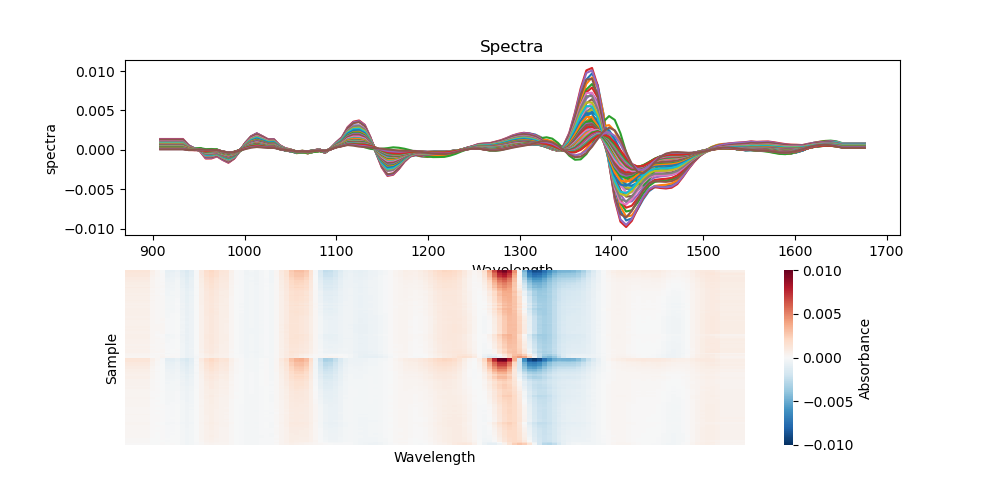

In [24]:
derispec = signal.savgol_filter(spectra,9, 2, 2)
plot_spectra_heatmap(spectra.columns,derispec,-0.01,0.01)